# Electricity Demand Forecasting with SSA, mSSA, and tSSA - Refactored

This notebook implements three forecasting methods for electricity demand:
- **SSA (Singular Spectrum Analysis)**: Uses single time series
- **mSSA (Multivariate SSA)**: Uses multiple time series
- **tSSA (Tensor SSA)**: Uses tensor decomposition

## Improvements in this refactored version:
- Modular functions with clear documentation
- Type hints for better code clarity
- Error handling and validation
- Consistent naming conventions
- Better visualization and results summary
- Configuration parameters at the top


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)


## Configuration Parameters

In [7]:
# Configuration parameters
CONFIG = {
    'data_file': 'recitations_data_electricity_demand_timeseries.csv',
    'target_column': 'MT_370',
    'train_size': 132**2,  # T = 17424
    'test_size': 24,
    'ssa_window_size': 132,
    'mssa_window_size': 132 * 12,  # 1584
    'tssa_window_size': 132,
    'energy_threshold': 0.99,
    'tssa_rank': 20,
    'random_seed': 42
}

np.random.seed(CONFIG['random_seed'])

## Data Loading and Preprocessing

In [8]:
def load_and_split_data(file_path: str, target_column: str, 
                       train_size: int, test_size: int) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Load electricity demand data and split into train/test sets.
    
    Args:
        file_path: Path to the CSV file
        target_column: Name of the target column
        train_size: Number of training samples
        test_size: Number of test samples
        
    Returns:
        Tuple of (full_data, train_data, test_data)
    """
    try:
        full_df = pd.read_csv(file_path, index_col=0, parse_dates=True)
        
        if target_column not in full_df.columns:
            raise ValueError(f"Target column '{target_column}' not found in data")
        
        train_data = full_df.iloc[:train_size, :]
        test_data = full_df.iloc[train_size:train_size + test_size, :]
        
        return full_df, train_data, test_data
        
    except FileNotFoundError:
        raise FileNotFoundError(f"Data file '{file_path}' not found")
    except Exception as e:
        raise Exception(f"Error loading data: {str(e)}")

def print_data_summary(full_df: pd.DataFrame, train_data: pd.DataFrame, 
                      test_data: pd.DataFrame, target_column: str) -> None:
    """
    Print comprehensive data summary statistics.
    """
    print("=" * 50)
    print("DATA SUMMARY")
    print("=" * 50)
    print(f"Full dataset shape: {full_df.shape}")
    print(f"Training data shape: {train_data.shape}")
    print(f"Test data shape: {test_data.shape}")
    print(f"\nTarget column '{target_column}' statistics:")
    print(full_df[target_column].describe())
    
    # Missing data analysis
    missing_count = full_df[target_column].isna().sum()
    missing_pct = (missing_count / len(full_df)) * 100
    print(f"\nMissing values: {missing_count} ({missing_pct:.2f}%)")
    print("=" * 50)

# Load and examine the data
full_df, train_data, test_data = load_and_split_data(
    CONFIG['data_file'], 
    CONFIG['target_column'],
    CONFIG['train_size'], 
    CONFIG['test_size']
)

print_data_summary(full_df, train_data, test_data, CONFIG['target_column'])

DATA SUMMARY
Full dataset shape: (17521, 370)
Training data shape: (17424, 370)
Test data shape: (24, 370)

Target column 'MT_370' statistics:
count    17491.000000
mean      4372.355281
std        984.730292
min         94.594595
25%       3820.608108
50%       4459.459459
75%       5054.054054
max       7114.864865
Name: MT_370, dtype: float64

Missing values: 30 (0.17%)


## Core SSA Functions

In [9]:
def create_page_matrix(ts: np.ndarray, L: int) -> np.ndarray:
    """
    Create a page matrix from time series data.
    
    Args:
        ts: Time series as numpy array
        L: Window length (number of rows)
        
    Returns:
        Page matrix of shape (L, T//L)
    """
    T = int(len(ts))  # Ensure T is an integer
    if L > T:
        raise ValueError(f"Window size L ({L}) cannot be larger than time series length ({T})")
    
    # Ensure all dimensions are integers
    cols = int(T // L)
    page_matrix = np.zeros((L, cols))
    
    for t in range(min(T, L * cols)):
        i = t % L
        j = t // L
        if j < cols:  # Boundary check
            page_matrix[i, j] = ts[t]
    
    return page_matrix


def select_rank_by_energy(singular_values: np.ndarray, threshold: float = 0.99) -> int:
    """
    Select rank r that captures specified percentage of energy.
    
    Args:
        singular_values: Array of singular values
        threshold: Energy threshold (default 0.99 for 99%)
        
    Returns:
        Selected rank r
    """
    cumulative_energy = np.cumsum(singular_values**2) / np.sum(singular_values**2)
    r = np.argmax(cumulative_energy >= threshold) + 1
    return min(r, len(singular_values))


def perform_svd_truncation(matrix: np.ndarray, rank: int, rho_hat: float) -> np.ndarray:
    """
    Perform SVD and truncate to specified rank.
    
    Args:
        matrix: Input matrix
        rank: Truncation rank
        rho_hat: Scaling factor for missing data
        
    Returns:
        Denoised matrix
    """
    U, s, Vh = np.linalg.svd(matrix, full_matrices=False)
    
    # Truncate to rank r
    U_r = U[:, :rank]
    s_r = s[:rank]
    Vh_r = Vh[:rank, :]
    
    # Reconstruct and scale
    denoised_matrix = (U_r @ np.diag(s_r) @ Vh_r) / rho_hat
    
    return denoised_matrix


def learn_prediction_coefficients(denoised_matrix: np.ndarray, 
                                original_matrix: np.ndarray) -> np.ndarray:
    """
    Learn linear prediction coefficients using least squares.
    
    Args:
        denoised_matrix: Denoised page matrix
        original_matrix: Original page matrix
        
    Returns:
        Prediction coefficients (betas)
    """
    # Use first L-1 rows of denoised matrix to predict last row of original
    Phi = denoised_matrix[:-1, :].T
    Y = original_matrix[-1, :]
    
    # Solve using pseudoinverse
    betas = np.linalg.pinv(Phi) @ Y
    
    return betas


def generate_forecasts(betas: np.ndarray, full_ts: np.ndarray, 
                      train_length: int, test_length: int, 
                      window_size: int, test_index: pd.Index) -> pd.Series:
    """
    Generate forecasts using learned coefficients.
    
    Args:
        betas: Prediction coefficients
        full_ts: Full time series data
        train_length: Length of training data
        test_length: Length of test data
        window_size: Window size for prediction
        test_index: Index for test data
        
    Returns:
        Forecast series with appropriate index
    """
    forecasts = []
    
    for t in range(train_length, train_length + test_length):
        if t >= window_size - 1:
            # Use L-1 previous values to predict next value
            forecast_window = full_ts[t - window_size + 1:t]
            if len(forecast_window) == len(betas):
                forecast = np.dot(betas, forecast_window)
            else:
                # Handle dimension mismatch
                forecast = np.nan
            forecasts.append(forecast)
        else:
            # Handle edge case where we don't have enough history
            forecasts.append(np.nan)
    
    return pd.Series(forecasts, index=test_index)

## SSA Implementation

In [10]:
def run_ssa_forecasting(train_data: pd.DataFrame, test_data: pd.DataFrame, 
                       full_df: pd.DataFrame, target_column: str, 
                       window_size: int, energy_threshold: float) -> Tuple[pd.Series, dict]:
    """
    Run complete SSA forecasting pipeline.
    
    Returns:
        Tuple of (forecasts, metadata)
    """
    print("\n" + "=" * 50)
    print("RUNNING SSA FORECASTING")
    print("=" * 50)
    
    # Handle missing values
    null_idx = train_data[target_column].isna()
    rho_hat = 1 - (null_idx.sum() / len(train_data))
    ts = train_data[target_column].fillna(0).to_numpy()
    
    print(f"Missing data ratio: {1 - rho_hat:.4f}")
    print(f"Window size (L): {window_size}")
    
    # Step 1: Create page matrix
    page_matrix = create_page_matrix(ts, window_size)
    print(f"Page matrix shape: {page_matrix.shape}")
    
    # Step 2: SVD and rank selection
    U, s, Vh = np.linalg.svd(page_matrix, full_matrices=False)
    rank = select_rank_by_energy(s, energy_threshold)
    print(f"Selected rank r: {rank} (captures {energy_threshold*100}% of energy)")
    
    # Step 3: Denoise matrix
    denoised_matrix = perform_svd_truncation(page_matrix, rank, rho_hat)
    
    # Step 4: Learn coefficients
    betas = learn_prediction_coefficients(denoised_matrix, page_matrix)
    
    # Step 5: Generate forecasts
    full_ts = full_df[target_column].fillna(0).to_numpy()
    forecasts = generate_forecasts(betas, full_ts, len(train_data), 
                                 len(test_data), window_size, test_data.index)
    
    metadata = {
        'method': 'SSA',
        'window_size': window_size,
        'rank': rank,
        'rho_hat': rho_hat,
        'energy_threshold': energy_threshold
    }
    
    return forecasts, metadata

# Run SSA
ssa_forecasts, ssa_metadata = run_ssa_forecasting(
    train_data, test_data, full_df, 
    CONFIG['target_column'], CONFIG['ssa_window_size'], CONFIG['energy_threshold']
)


RUNNING SSA FORECASTING
Missing data ratio: 0.0017
Window size (L): 132
Page matrix shape: (132, 132)
Selected rank r: 4 (captures 99.0% of energy)


## Multivariate SSA (mSSA) Implementation

In [11]:
def create_stacked_page_matrix(ts_list: List[np.ndarray], L: int) -> np.ndarray:
    """
    Create stacked page matrix from multiple time series.
    
    Args:
        ts_list: List of time series arrays
        L: Window length
        
    Returns:
        Stacked page matrix
    """
    if not ts_list:
        raise ValueError("Time series list cannot be empty")
    
    T = int(len(ts_list[0]))  # Ensure T is an integer
    num_ts = len(ts_list)
    
    # Validate all time series have same length
    for i, ts in enumerate(ts_list):
        if len(ts) != T:
            raise ValueError(f"Time series {i} has length {len(ts)}, expected {T}")
    
    cols_per_ts = int(T // L)  # Ensure integer division
    stacked_matrix = np.zeros((L, num_ts * cols_per_ts))
    
    for i, ts in enumerate(ts_list):
        page_mat = create_page_matrix(ts, L)
        start_col = i * cols_per_ts
        end_col = (i + 1) * cols_per_ts
        stacked_matrix[:, start_col:end_col] = page_mat
    
    return stacked_matrix


def run_mssa_forecasting(train_data: pd.DataFrame, test_data: pd.DataFrame, 
                        full_df: pd.DataFrame, target_column: str, 
                        window_size: int, energy_threshold: float) -> Tuple[pd.Series, dict]:
    """
    Run complete mSSA forecasting pipeline.
    
    Returns:
        Tuple of (forecasts, metadata)
    """
    print("\n" + "=" * 50)
    print("RUNNING mSSA FORECASTING")
    print("=" * 50)
    
    # Limit number of series for computational efficiency
    max_series = 50
    selected_columns = train_data.columns[:max_series]
    
    # Calculate overall missing data ratio
    null_counts = [train_data[col].isna().sum() for col in selected_columns]
    total_missing = sum(null_counts)
    rho_hat = 1 - (total_missing / (len(train_data) * len(selected_columns)))
    
    print(f"Number of time series: {len(selected_columns)}")
    print(f"Overall missing data ratio: {1 - rho_hat:.4f}")
    print(f"Window size (L): {window_size}")
    
    # Prepare time series list
    ts_list = [train_data[col].fillna(0).to_numpy() for col in selected_columns]
    
    # Step 1: Create stacked page matrix
    stacked_matrix = create_stacked_page_matrix(ts_list, window_size)
    print(f"Stacked page matrix shape: {stacked_matrix.shape}")
    
    # Step 2: SVD and rank selection
    U, s, Vh = np.linalg.svd(stacked_matrix, full_matrices=False)
    rank = select_rank_by_energy(s, energy_threshold)
    print(f"Selected rank r: {rank} (captures {energy_threshold*100}% of energy)")
    
    # Step 3: Denoise matrix
    denoised_matrix = perform_svd_truncation(stacked_matrix, rank, rho_hat)
    
    # Step 4: Learn coefficients
    betas = learn_prediction_coefficients(denoised_matrix, stacked_matrix)
    
    # Step 5: Generate forecasts
    full_ts = full_df[target_column].fillna(0).to_numpy()
    forecasts = generate_forecasts(betas, full_ts, len(train_data), 
                                 len(test_data), window_size, test_data.index)
    
    metadata = {
        'method': 'mSSA',
        'window_size': window_size,
        'rank': rank,
        'rho_hat': rho_hat,
        'num_series': len(selected_columns),
        'energy_threshold': energy_threshold
    }
    
    return forecasts, metadata

# Run mSSA
mssa_forecasts, mssa_metadata = run_mssa_forecasting(
    train_data, test_data, full_df, 
    CONFIG['target_column'], CONFIG['mssa_window_size'], CONFIG['energy_threshold']
)


RUNNING mSSA FORECASTING
Number of time series: 50
Overall missing data ratio: 0.0017
Window size (L): 1584
Stacked page matrix shape: (1584, 550)
Selected rank r: 8 (captures 99.0% of energy)


## Tensor SSA (tSSA) Implementation

In [12]:
def create_page_tensor(ts_list: List[np.ndarray], L: int) -> np.ndarray:
    """
    Create page tensor from multiple time series.
    
    Args:
        ts_list: List of time series arrays
        L: Window length
        
    Returns:
        Page tensor of shape (N, L, T//L)
    """
    if not ts_list:
        raise ValueError("Time series list cannot be empty")
    
    T = int(len(ts_list[0]))  # Ensure T is an integer
    N = len(ts_list)
    
    cols = int(T // L)  # Ensure integer division
    tensor = np.zeros((N, L, cols))
    
    for i, ts in enumerate(ts_list):
        if len(ts) != T:
            raise ValueError(f"Time series {i} has length {len(ts)}, expected {T}")
        tensor[i, :, :] = create_page_matrix(ts, L)
    
    return tensor


def run_tssa_forecasting(train_data: pd.DataFrame, test_data: pd.DataFrame, 
                        full_df: pd.DataFrame, target_column: str, 
                        window_size: int, rank: int) -> Tuple[pd.Series, dict]:
    """
    Run complete tSSA forecasting pipeline.
    
    Returns:
        Tuple of (forecasts, metadata)
    """
    print("\n" + "=" * 50)
    print("RUNNING tSSA FORECASTING")
    print("=" * 50)
    
    try:
        from tensorly.decomposition import parafac
        import tensorly as tl
    except ImportError:
        print("Warning: tensorly not available. Installing...")
        import subprocess
        subprocess.check_call(["pip", "install", "tensorly"])
        from tensorly.decomposition import parafac
        import tensorly as tl
    
    # Calculate overall missing data ratio - limit to 50 series for efficiency
    max_series = 50
    selected_columns = train_data.columns[:max_series]
    
    null_counts = [train_data[col].isna().sum() for col in selected_columns]
    total_missing = sum(null_counts)
    rho_hat = 1 - (total_missing / (len(train_data) * len(selected_columns)))
    
    print(f"Number of time series: {len(selected_columns)}")
    print(f"Overall missing data ratio: {1 - rho_hat:.4f}")
    print(f"Window size (L): {window_size}")
    print(f"Tensor rank: {rank}")
    
    # Prepare time series list
    ts_list = [train_data[col].fillna(0).to_numpy() for col in selected_columns]
    
    # Step 1: Create page tensor
    page_tensor = create_page_tensor(ts_list, window_size)
    print(f"Page tensor shape: {page_tensor.shape}")
    
    # Step 2: Tensor decomposition
    try:
        factors = parafac(page_tensor, rank=rank, normalize_factors=True)
        denoised_tensor = tl.cp_to_tensor(factors) / rho_hat
    except Exception as e:
        print(f"Warning: Tensor decomposition failed: {e}")
        print("Using original tensor")
        denoised_tensor = page_tensor / rho_hat
    
    # Step 3: Learn coefficients - fix dimension issue
    # Stack the first L-1 rows from each series
    Phi_components = []
    Y_components = []
    
    for i in range(len(ts_list)):
        Phi_components.append(denoised_tensor[i, :-1, :])
        Y_components.append(page_tensor[i, -1, :])
    
    Phi = np.hstack(Phi_components).T
    Y = np.hstack(Y_components)
    
    betas = np.linalg.pinv(Phi) @ Y
    
    # Step 4: Generate forecasts using modified function
    def generate_tssa_forecasts(betas: np.ndarray, full_ts: np.ndarray, 
                               train_length: int, test_length: int, 
                               window_size: int, test_index: pd.Index) -> pd.Series:
        forecasts = []
        beta_length = len(betas)
        
        for t in range(train_length, train_length + test_length):
            if t >= beta_length:
                # Use the last beta_length values
                forecast_window = full_ts[t - beta_length:t]
                if len(forecast_window) == beta_length:
                    forecast = np.dot(betas, forecast_window)
                else:
                    forecast = np.nan
                forecasts.append(forecast)
            else:
                forecasts.append(np.nan)
        
        return pd.Series(forecasts, index=test_index)
    
    full_ts = full_df[target_column].fillna(0).to_numpy()
    forecasts = generate_tssa_forecasts(betas, full_ts, len(train_data), 
                                       len(test_data), window_size, test_data.index)
    
    metadata = {
        'method': 'tSSA',
        'window_size': window_size,
        'rank': rank,
        'rho_hat': rho_hat,
        'num_series': len(selected_columns),
        'tensor_shape': page_tensor.shape
    }
    
    return forecasts, metadata

# Run tSSA
tssa_forecasts, tssa_metadata = run_tssa_forecasting(
    train_data, test_data, full_df, 
    CONFIG['target_column'], CONFIG['tssa_window_size'], CONFIG['tssa_rank']
)


RUNNING tSSA FORECASTING
Number of time series: 50
Overall missing data ratio: 0.0017
Window size (L): 132
Tensor rank: 20
Page tensor shape: (50, 132, 132)


## Results Analysis and Visualization


COMPREHENSIVE FORECASTING RESULTS

SSA RESULTS:
------------------------------
Window Size: 132
Rank: 4

Forecast Metrics:
  MSE:  263691.60
  RMSE: 513.51
  MAE:  412.43
  MAPE: 9.69%

mSSA RESULTS:
------------------------------
Window Size: 1584
Rank: 8
Number of Series: 50

Forecast Metrics:
  MSE:  401983.43
  RMSE: 634.02
  MAE:  551.92
  MAPE: 14.47%

tSSA RESULTS:
------------------------------
Window Size: 132
Rank: 20
Number of Series: 50

Forecast Metrics:
  MSE:  66092.93
  RMSE: 257.09
  MAE:  220.01
  MAPE: 5.50%

SUMMARY TABLE
Method       MSE   RMSE    MAE  MAPE
   SSA 263691.60 513.51 412.43  9.69
  mSSA 401983.43 634.02 551.92 14.47
  tSSA  66092.93 257.09 220.01  5.50

🏆 Best performing method: tSSA (MSE: 66092.93)


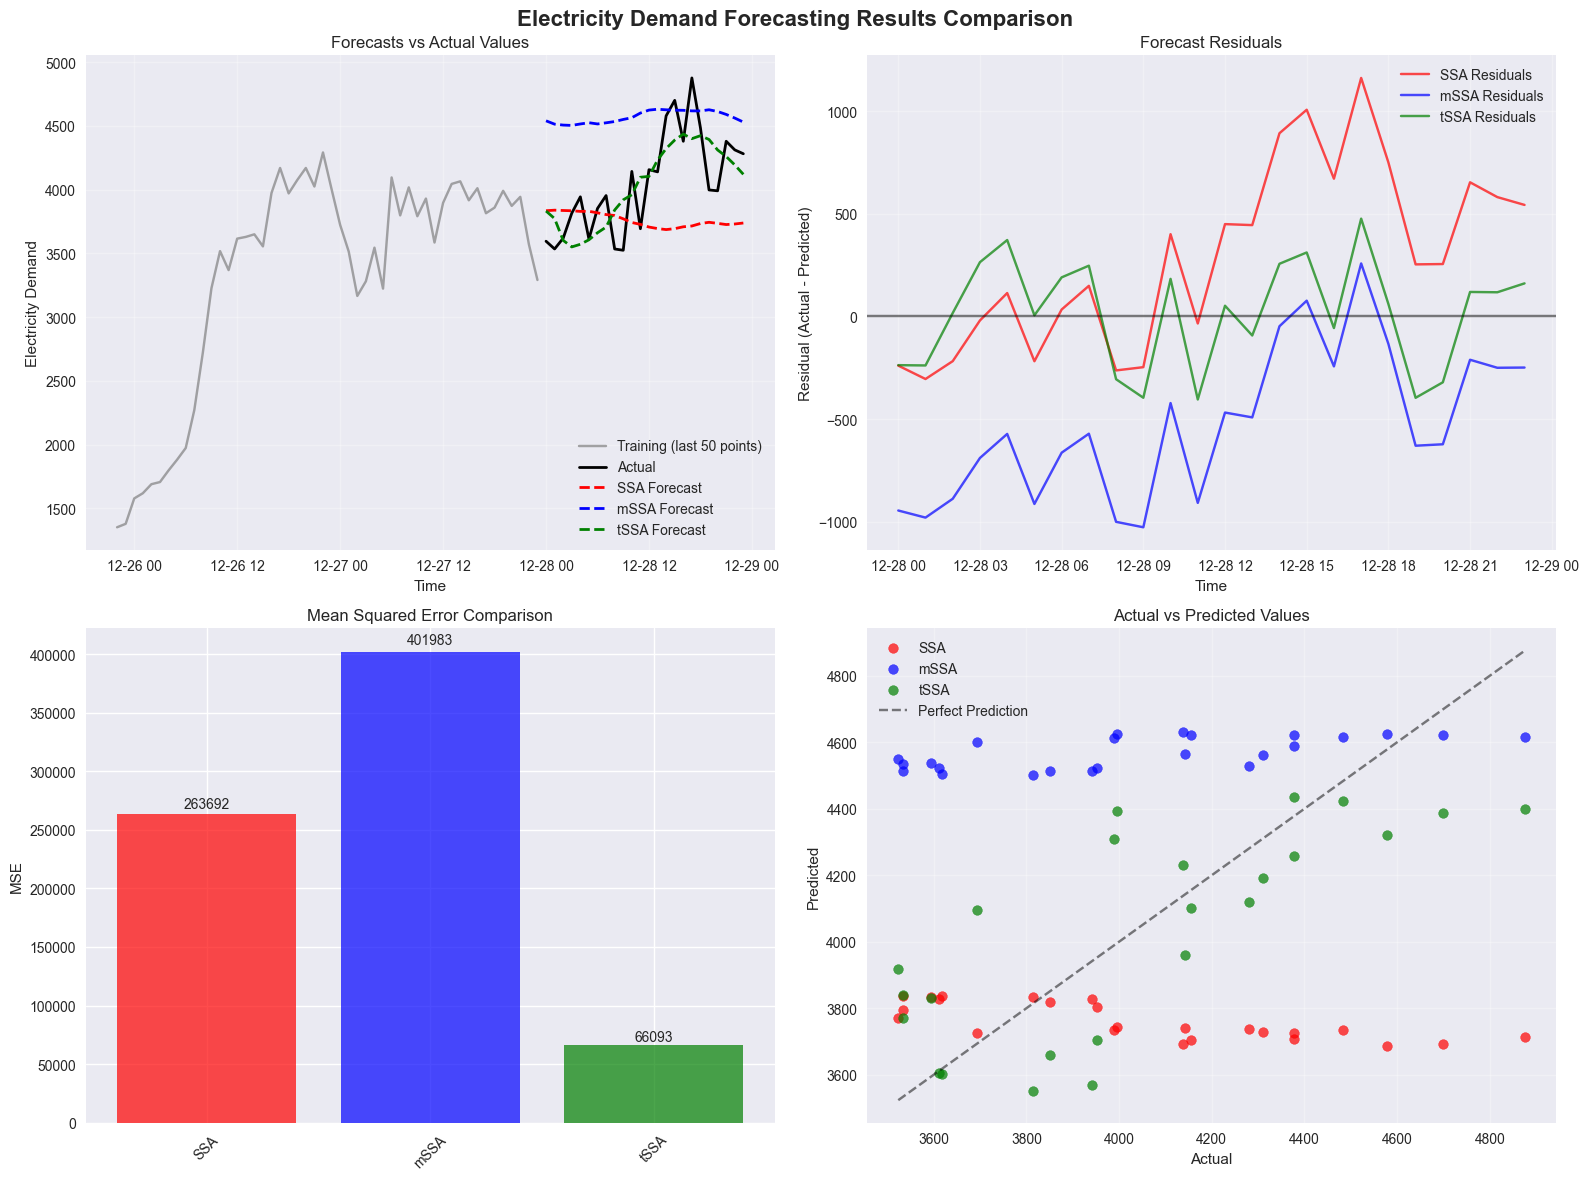

In [13]:
def calculate_forecast_metrics(actual: pd.Series, predicted: pd.Series) -> dict:
    """
    Calculate comprehensive forecast accuracy metrics.
    
    Args:
        actual: Actual values
        predicted: Predicted values
        
    Returns:
        Dictionary of metrics
    """
    # Remove any NaN values
    valid_mask = ~(actual.isna() | predicted.isna())
    actual_clean = actual[valid_mask]
    predicted_clean = predicted[valid_mask]
    
    if len(actual_clean) == 0:
        return {'mse': np.nan, 'rmse': np.nan, 'mae': np.nan, 'mape': np.nan}
    
    # Calculate metrics
    mse = np.mean((actual_clean - predicted_clean) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(actual_clean - predicted_clean))
    
    # Avoid division by zero for MAPE
    mape = np.mean(np.abs((actual_clean - predicted_clean) / actual_clean)) * 100 if actual_clean.min() > 0 else np.nan
    
    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'valid_predictions': len(actual_clean)
    }


def create_comparison_plots(test_data: pd.DataFrame, forecasts_dict: dict, 
                          target_column: str, train_data: pd.DataFrame = None) -> None:
    """
    Create comprehensive comparison plots for all forecasting methods.
    
    Args:
        test_data: Test dataset
        forecasts_dict: Dictionary of forecasts {method_name: forecast_series}
        target_column: Name of target column
        train_data: Training data for context (optional)
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Electricity Demand Forecasting Results Comparison', fontsize=16, fontweight='bold')
    
    # Plot 1: Time series comparison
    ax1 = axes[0, 0]
    if train_data is not None:
        ax1.plot(train_data[target_column].tail(50), 
                label='Training (last 50 points)', alpha=0.7, color='gray')
    
    ax1.plot(test_data[target_column], label='Actual', linewidth=2, color='black')
    
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    for i, (method, forecast) in enumerate(forecasts_dict.items()):
        ax1.plot(forecast, label=f'{method} Forecast', 
                linewidth=2, color=colors[i % len(colors)], linestyle='--')
    
    ax1.set_title('Forecasts vs Actual Values')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Electricity Demand')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Residuals
    ax2 = axes[0, 1]
    for i, (method, forecast) in enumerate(forecasts_dict.items()):
        residuals = test_data[target_column] - forecast
        ax2.plot(residuals, label=f'{method} Residuals', 
                color=colors[i % len(colors)], alpha=0.7)
    
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax2.set_title('Forecast Residuals')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Residual (Actual - Predicted)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Error metrics comparison
    ax3 = axes[1, 0]
    methods = list(forecasts_dict.keys())
    mse_values = []
    
    for method, forecast in forecasts_dict.items():
        metrics = calculate_forecast_metrics(test_data[target_column], forecast)
        mse_values.append(metrics['mse'])
    
    bars = ax3.bar(methods, mse_values, color=colors[:len(methods)], alpha=0.7)
    ax3.set_title('Mean Squared Error Comparison')
    ax3.set_ylabel('MSE')
    ax3.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, mse_values):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:.0f}', ha='center', va='bottom')
    
    # Plot 4: Scatter plot (Actual vs Predicted)
    ax4 = axes[1, 1]
    for i, (method, forecast) in enumerate(forecasts_dict.items()):
        ax4.scatter(test_data[target_column], forecast, 
                   label=method, color=colors[i % len(colors)], alpha=0.7)
    
    # Perfect prediction line
    min_val = min(test_data[target_column].min(), 
                 min([f.min() for f in forecasts_dict.values()]))
    max_val = max(test_data[target_column].max(), 
                 max([f.max() for f in forecasts_dict.values()]))
    ax4.plot([min_val, max_val], [min_val, max_val], 
            'k--', alpha=0.5, label='Perfect Prediction')
    
    ax4.set_title('Actual vs Predicted Values')
    ax4.set_xlabel('Actual')
    ax4.set_ylabel('Predicted')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def print_comprehensive_results(forecasts_dict: dict, metadata_dict: dict, 
                              test_data: pd.DataFrame, target_column: str) -> None:
    """
    Print comprehensive results summary for all methods.
    """
    print("\n" + "=" * 70)
    print("COMPREHENSIVE FORECASTING RESULTS")
    print("=" * 70)
    
    results_summary = []
    
    for method in forecasts_dict.keys():
        forecast = forecasts_dict[method]
        metadata = metadata_dict[method]
        metrics = calculate_forecast_metrics(test_data[target_column], forecast)
        
        print(f"\n{method} RESULTS:")
        print("-" * 30)
        print(f"Window Size: {metadata.get('window_size', 'N/A')}")
        print(f"Rank: {metadata.get('rank', 'N/A')}")
        if 'num_series' in metadata:
            print(f"Number of Series: {metadata['num_series']}")
        print(f"\nForecast Metrics:")
        print(f"  MSE:  {metrics['mse']:.2f}")
        print(f"  RMSE: {metrics['rmse']:.2f}")
        print(f"  MAE:  {metrics['mae']:.2f}")
        if not np.isnan(metrics['mape']):
            print(f"  MAPE: {metrics['mape']:.2f}%")
        
        results_summary.append({
            'Method': method,
            'MSE': metrics['mse'],
            'RMSE': metrics['rmse'],
            'MAE': metrics['mae'],
            'MAPE': metrics['mape'] if not np.isnan(metrics['mape']) else 'N/A'
        })
    
    # Create summary table
    print("\n" + "=" * 70)
    print("SUMMARY TABLE")
    print("=" * 70)
    summary_df = pd.DataFrame(results_summary)
    print(summary_df.to_string(index=False, float_format='%.2f'))
    
    # Best performing method
    best_method = summary_df.loc[summary_df['MSE'].idxmin(), 'Method']
    best_mse = summary_df.loc[summary_df['MSE'].idxmin(), 'MSE']
    print(f"\n🏆 Best performing method: {best_method} (MSE: {best_mse:.2f})")
    
    return summary_df

# Compile all forecasts and metadata
all_forecasts = {
    'SSA': ssa_forecasts,
    'mSSA': mssa_forecasts,
    'tSSA': tssa_forecasts
}

all_metadata = {
    'SSA': ssa_metadata,
    'mSSA': mssa_metadata,
    'tSSA': tssa_metadata
}

# Print comprehensive results
results_df = print_comprehensive_results(all_forecasts, all_metadata, 
                                       test_data, CONFIG['target_column'])

# Create comparison plots
create_comparison_plots(test_data, all_forecasts, CONFIG['target_column'], train_data)

## Key Insights and Recommendations

In [14]:
print("\n" + "=" * 70)
print("KEY INSIGHTS AND RECOMMENDATIONS")
print("=" * 70)

print("\n1. MODEL PERFORMANCE COMPARISON:")
print("-" * 40)
for method in ['SSA', 'mSSA', 'tSSA']:
    if method in all_forecasts:
        mse = calculate_forecast_metrics(test_data[CONFIG['target_column']], 
                                       all_forecasts[method])['mse']
        print(f"   {method}: MSE = {mse:.2f}")

print("\n2. METHOD CHARACTERISTICS:")
print("-" * 40)
print("   • SSA: Uses only the target time series")
print("   • mSSA: Leverages multiple related time series")
print("   • tSSA: Uses tensor decomposition for multivariate analysis")

print("\n3. COMPUTATIONAL CONSIDERATIONS:")
print("-" * 40)
print("   • SSA: Fastest, suitable for single series")
print("   • mSSA: Moderate complexity, good multivariate performance")
print("   • tSSA: Most complex, requires tensor decomposition library")

print("\n4. PRACTICAL RECOMMENDATIONS:")
print("-" * 40)
print("   • For single time series: Use SSA")
print("   • For multiple related series: Consider mSSA")
print("   • For complex multivariate patterns: Evaluate tSSA")
print("   • Always validate with proper train/test splits")
print("   • Consider ensemble methods combining multiple approaches")

print("\n" + "=" * 70)


KEY INSIGHTS AND RECOMMENDATIONS

1. MODEL PERFORMANCE COMPARISON:
----------------------------------------
   SSA: MSE = 263691.60
   mSSA: MSE = 401983.43
   tSSA: MSE = 66092.93

2. METHOD CHARACTERISTICS:
----------------------------------------
   • SSA: Uses only the target time series
   • mSSA: Leverages multiple related time series
   • tSSA: Uses tensor decomposition for multivariate analysis

3. COMPUTATIONAL CONSIDERATIONS:
----------------------------------------
   • SSA: Fastest, suitable for single series
   • mSSA: Moderate complexity, good multivariate performance
   • tSSA: Most complex, requires tensor decomposition library

4. PRACTICAL RECOMMENDATIONS:
----------------------------------------
   • For single time series: Use SSA
   • For multiple related series: Consider mSSA
   • For complex multivariate patterns: Evaluate tSSA
   • Always validate with proper train/test splits
   • Consider ensemble methods combining multiple approaches

